<h1>Tutorial 4: Pipeline</h1>

<h2>Overview</h2>

In this tutorial, we will talk about the following:

* Pipeline API
    * Tensorflow and PyTorch datasets in Pipeline
    * Using FastEstimator dataset API
* How to use operators in Pipeline
    * Basic concepts about operators
    * Univariate and Multivariate operators
    * Customized operators
* Example of Pipeline

In deep learning, data preprocessing is a way of converting data from the raw form to a much more usable or desired form. It is one crucial step in the model training as it directly affects the ability of model to learn. <br>
`Pipeline` API operates by enabling such tasks in efficient manner. It takes care of extracting data from the disk and preprocessing before feeding it to the model. `Pipeline` operations usually happen on CPU.

<h2>Loading data in Pipeline</h2>

In tutorial 2[link], we demonstrated the different types of datasets. We will see how datasets can be loaded in the `Pipeline` and various operations can be applied to the data. We will create a simple pipeline using `tf.data.Dataset` and `torch.data.Dataloader`.

In [1]:
import fastestimator as fe
import tensorflow as tf
import torch
from torch.utils import data
import numpy as np

train_data, eval_data, test_data = (np.random.sample((100,2)), np.random.sample((100,1)), np.random.sample((100, 1)))

# create tf.data.Datasets from sample data
dataset_tf = tf.data.Dataset.from_tensor_slices((train_data, eval_data, test_data))

# create torch.data.Dataloader from sample data
dataset_torch = data.TensorDataset(torch.Tensor(train_data), torch.Tensor(eval_data), torch.Tensor(test_data))
dataloader_torch = data.DataLoader(dataset_torch)

# load data into pipeline
pipeline_tf = fe.Pipeline(dataset_tf)
pipeline_torch = fe.Pipeline(dataloader_torch)

Let's print `Pipeline` results using `fe.pipeline.get_results`. It is used to debug and inspect operation outputs in the `Pipeline`

In [2]:
pipeline_tf.get_results(num_steps=2)

[(<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.45372089, 0.97197802])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.47420937])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.42508281])>),
 (<tf.Tensor: shape=(2,), dtype=float64, numpy=array([0.46349756, 0.80163207])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.87881811])>,
  <tf.Tensor: shape=(1,), dtype=float64, numpy=array([0.43175111])>)]

In [3]:
pipeline_torch.get_results(num_steps=2)

[[tensor([[0.4537, 0.9720]]), tensor([[0.4742]]), tensor([[0.4251]])],
 [tensor([[0.4635, 0.8016]]), tensor([[0.8788]]), tensor([[0.4318]])]]

<h3>Using FastEstimator Dataset</h3>

Next, we will see how to use one of the Fastestimator Dataset in the `Pipeline`. We will create `fe.dataset.NumpyDataset` and load it into pipeline. As we saw in tutorial 2, `NumpyDataset` takes dictionary with keys for <b>Input data</b> and <b>Ground truth label</b>

In [4]:
from fastestimator.dataset.numpy_dataset import NumpyDataset

x_train, y_train = (np.random.sample((100, 2)), np.random.sample((100, 1)))
x_eval, y_eval = (np.random.sample((100, 2)), np.random.sample((100, 1)))

# create NumpyDataset from the sample data
train_data = NumpyDataset({"x": x_train, "y": y_train})
eval_data = NumpyDataset({"x": x_eval, "y": y_eval})

pipeline_fe = fe.Pipeline(train_data=train_data, eval_data=eval_data, batch_size=1)

Now, let's print the output of the `pipeline_fe`

In [5]:
pipeline_fe.get_results(num_steps=2)

[{'x': tensor([[0.7866, 0.7127]], dtype=torch.float64),
  'y': tensor([[0.1185]], dtype=torch.float64)},
 {'x': tensor([[0.7977, 0.2604]], dtype=torch.float64),
  'y': tensor([[0.6098]], dtype=torch.float64)}]

<h2>How to use operators in Pipeline</h2>

In tutorial 3, we learned about the `Operators` and their structures. They are used in FastEstimator for constructing workflow graphs. Here we will talk about Numpy Operator (NumpyOp) and how to use them in `Pipeline`.

`NumpyOp` inherits base class `Op` and performs preprocessing and augmentation tasks on non-Tensor data. With combination of `NumpyOp`, preprocessing tasks become considerably easier in just few lines of code. Many of the augmentation operations leverages the image augmentation library [albumentations](https://github.com/albumentations-team/albumentations). <br>
`NumpyOp` can be classified in three main classes:
   * Univariate Ops
   * Multivariate Ops
   * Meta Ops
   
In addition to that, we can customize the `NumpyOp` to perform our own operations on the data. Inheriting `fe.op.numpyop` we can create custom `NumpyOp` and use it in `Pipeline`.

<h3>Univariate Ops</h3>

Univariate operaters involve performing operations on one variable from the data dictionary at a time. They also support <b>multiple io</b> operations that can take multiple keys to perform same transform operations on the data.<br>
Let's perform a `Minmax` operation on a key "x" in previously defined FastEstimator dataset and write results to the same key.

In [6]:
from fastestimator.op.numpyop.univariate import Minmax

pipeline_fe = fe.Pipeline(train_data=train_data, 
                          eval_data=eval_data,
                          ops=[Minmax(inputs="x",outputs="x")],
                          batch_size=1)

As a result the output will be

In [7]:
pipeline_fe.get_results(num_steps=1)

{'x': tensor([[1., 0.]]), 'y': tensor([[0.1185]], dtype=torch.float64)}

<h3>Multivariate Ops</h3>

Multivariate operaters takes multiple variables from the data dictionary and perform operation on them simultaneously. For example, for input data it will change both input change as well as bounding box or masks at the same time.

To demonstrate multivariate operation, we will first load Fashion MNIST dataset in the `Pipeline` and then perform `CenterCrop` operation that crops the center of the image.

In [8]:
from fastestimator.op.numpyop.multivariate import CenterCrop
from fastestimator.dataset.data import mnist

mnist_train, mnist_eval = mnist.load_data()

pipeline_fe = fe.Pipeline(train_data=mnist_train,
                          eval_data=mnist_eval,
                          ops=[CenterCrop(image_in="x", image_out="x_out", height=20, width=20)],
                          batch_size=1)

We now have two keys in dictionary "x" and "x_out" representing input and output images respectively. Let's visualize the both images to see the results.

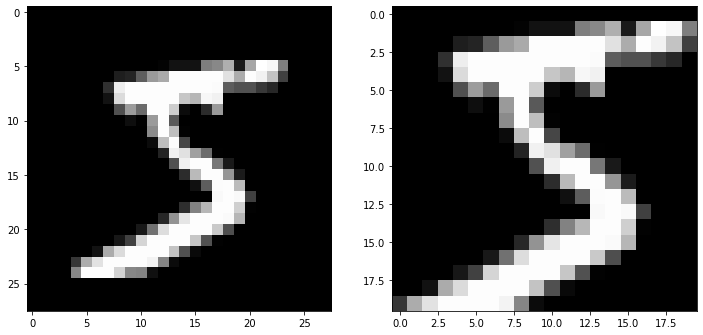

In [9]:
import matplotlib.pyplot as plt

results = pipeline_fe.get_results()

fig, axs = plt.subplots(1, 2, figsize=(12,12))
img_in = results['x'].numpy()[0]
axs[0].imshow(img_in, cmap="gray")

img_out = results['x_out'].numpy()[0]
axs[1].imshow(img_out, cmap="gray")

<h3>Custom NumpyOp</h3>

Let's create custom Numpy operator that add random noise to the numpy array.

In [10]:
from fastestimator.op.numpyop import NumpyOp

class AddRandomNoise(NumpyOp):
    def forward(self, data, state):
        # generate noise array with 0 mean and 1 standard deviation
        noise = np.random.normal(0, 1, data.shape)
        data = data + noise
        return data
    
pipeline_fe = fe.Pipeline(train_data=train_data, 
                          eval_data=eval_data,
                          ops=[AddRandomNoise(inputs="x",outputs="x")],
                          batch_size=1)

In [11]:
pipeline_fe.get_results(num_steps=2)

[{'x': tensor([[ 0.8622, -1.1923]], dtype=torch.float64),
  'y': tensor([[0.1185]], dtype=torch.float64)},
 {'x': tensor([[ 0.8360, -0.0328]], dtype=torch.float64),
  'y': tensor([[0.6098]], dtype=torch.float64)}]

<h2>Pipeline Example with MNIST dataset</h2>

We use MNIST dataset to demonstrate data preprocessing using various `NumpyOp` in the `Pipeline`. We will load the dataset from the `fastestimator.dataset` API and split it into train, eval and test set.

We will series of operations in the `Pipeline` such as Expand dimension, Minmax scaling and Image rotation.

In [12]:
from fastestimator.dataset.data import mnist
from fastestimator.op.numpyop.univariate import Minmax, ExpandDims
from fastestimator.op.numpyop.multivariate import Rotate

train_data, eval_data = mnist.load_data()
test_data = eval_data.split(0.5)
pipeline = fe.Pipeline(train_data=train_data,
                       eval_data=eval_data,
                       test_data=test_data,
                       ops=[ExpandDims(inputs="x", outputs="x_out"), 
                            Minmax(inputs="x_out", outputs="x_out"),
                            Rotate(image_in="x_out", image_out="x_out", limit=45)],
                      batch_size=2)

Let's get the `Pipeline` results and visualize the input and output images

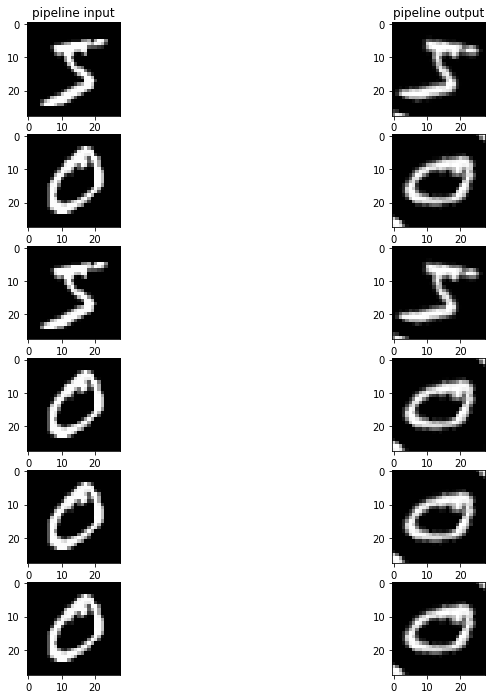

In [13]:
sample_num = 6

# get the pipeline results
data = pipeline.get_results()
data_xin = data["x"]
data_xout = data["x_out"]

# define subplots 
fig, axs = plt.subplots(sample_num, 2, figsize=(12,12))

axs[0,0].set_title("pipeline input")
axs[0,1].set_title("pipeline output")

# iterate over sample to plot the results
for i, j in enumerate(np.random.randint(low=0, high=2, size=sample_num)):
    img_in = data_xin.numpy()[j]
    axs[i,0].imshow(img_in, cmap="gray")
    
    img_out = data_xout.numpy()[j,:,:,0]
    axs[i,1].imshow(img_out, cmap="gray")